In [2]:
# /* 1. Separate X and y
# 2. Train-Test Split
# 3. Feature Scaling (ONLY on X_train)
# 4. Handle Imbalance (ONLY on training data)
# 5. Train Logistic Regression
# 6. Evaluate using Precision, Recall, F1/


In [3]:
# import sklearn
# sklearn.set_config(transform_output="pandas")

In [4]:
import pandas as pd
import numpy as np

np.random.seed(42)


rows = 9000

data = {
    "income": np.random.normal(50000, 20000, rows),
    "debts": np.random.normal(15000, 10000, rows),
    "credit_score": np.random.randint(300, 850, rows),
    "employment_years": np.random.randint(0, 35, rows),
    "loan_amount": np.random.normal(20000, 15000, rows),
    "payment_history": np.random.randint(0, 6, rows),
    "age": np.random.randint(18, 70, rows),
    "loan_term": np.random.choice([12, 24, 36, 48, 60], rows)
}

df = pd.DataFrame(data)

# ---------- Target Variable ----------
df["creditworthy"] = np.where(
    (df["credit_score"] > 650) &
    (df["payment_history"] <= 1) &
    (df["income"] > df["loan_amount"] / 2),
    1,
    0
)

# ---------- Introduce Missing Values ----------
for col in df.columns:
    df.loc[df.sample(frac=0.08).index, col] = np.nan

# ---------- Messy Data ----------
df.loc[df.sample(frac=0.03).index, "income"] *= -1   # negative income
df.loc[df.sample(frac=0.03).index, "debts"] *= 5     # extreme debts

df.sample(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
3135,58860.042609,19340.684872,469.0,11.0,16726.394368,3.0,32.0,60.0,0.0
2758,NaN,19137.542029,379.0,17.0,26065.495292,4.0,57.0,12.0,0.0


HANDLING_INCORRECT_DATA

In [5]:
df['income']  = df['income'].abs()

In [6]:
df[df['income'] < 0]

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy


In [7]:
cols = [i for i in df.columns]
for i in range(len(df.columns)):
    df[cols[i]] = df[cols[i]].abs()
    

In [8]:
df.sample(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
8580,53478.944168,29022.095895,361.0,23.0,32204.782041,1.0,51.0,24.0,0.0
668,3019.396168,5750.741843,725.0,4.0,NaN,1.0,41.0,36.0,0.0


In [9]:
print('income' ,df['income'].mean(),"debths",df['debts'].mean(),"credit_score",df['credit_score'].mean(),"employment_years",df['employment_years'].median(),"loan_amount",df['loan_amount'].median())

income 49984.73253228217 debths 17611.375167424583 credit_score 574.4972222222223 employment_years 17.0 loan_amount 19995.07859304758


In [10]:
df.columns

Index(['income', 'debts', 'credit_score', 'employment_years', 'loan_amount',
       'payment_history', 'age', 'loan_term', 'creditworthy'],
      dtype='object')

HANDLING MISSING DATA

In [11]:
(((df['income'].isnull().sum()/ len(df))*100) *9) 

np.float64(72.0)

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline



In [13]:
df['debts'].mean(),df['debts'].median()
df['loan_amount'].mean(),df['loan_amount'].median()

(np.float64(21235.532936896278), 19995.07859304758)

In [14]:
df.head(1)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.28306,22654.02156,813.0,8.0,15537.525878,3.0,20.0,12.0,NaN


In [15]:
df

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.283060,22654.021560,813.0,8.0,15537.525878,3.0,20.0,12.0,NaN
1,47234.713977,25734.127024,848.0,17.0,38487.292308,4.0,65.0,12.0,0.0
2,62953.770762,19986.899121,396.0,34.0,4853.224190,4.0,21.0,12.0,0.0
3,80460.597128,4424.976910,669.0,30.0,22767.297917,5.0,64.0,12.0,0.0
4,45316.932506,13445.775675,716.0,23.0,38691.012183,3.0,66.0,36.0,0.0
...,...,...,...,...,...,...,...,...,...
8995,52032.601071,24849.501030,693.0,NaN,6435.267093,3.0,22.0,24.0,0.0
8996,73344.354666,7166.912433,426.0,NaN,26025.650900,3.0,31.0,36.0,NaN
8997,81768.943525,22852.553596,413.0,14.0,34842.601430,1.0,51.0,36.0,0.0
8998,36300.256417,3506.954226,824.0,6.0,NaN,NaN,27.0,36.0,NaN


In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [17]:
# cols = [i for i in df.columns]
# df = pd.DataFrame(imputation.fit_transform(df),columns=cols)

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income            8280 non-null   float64
 1   debts             8280 non-null   float64
 2   credit_score      8280 non-null   float64
 3   employment_years  8280 non-null   float64
 4   loan_amount       8280 non-null   float64
 5   payment_history   8280 non-null   float64
 6   age               8280 non-null   float64
 7   loan_term         8280 non-null   float64
 8   creditworthy      8280 non-null   float64
dtypes: float64(9)
memory usage: 632.9 KB


In [19]:
type(df.columns)

pandas.core.indexes.base.Index

In [20]:
df = df.fillna(df.median())

In [21]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


In [22]:
df 

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.283060,22654.021560,813.0,8.0,15537.525878,3.0,20.0,12.0,0.0
1,47234.713977,25734.127024,848.0,17.0,38487.292308,4.0,65.0,12.0,0.0
2,62953.770762,19986.899121,396.0,34.0,4853.224190,4.0,21.0,12.0,0.0
3,80460.597128,4424.976910,669.0,30.0,22767.297917,5.0,64.0,12.0,0.0
4,45316.932506,13445.775675,716.0,23.0,38691.012183,3.0,66.0,36.0,0.0
...,...,...,...,...,...,...,...,...,...
8995,52032.601071,24849.501030,693.0,17.0,6435.267093,3.0,22.0,24.0,0.0
8996,73344.354666,7166.912433,426.0,17.0,26025.650900,3.0,31.0,36.0,0.0
8997,81768.943525,22852.553596,413.0,14.0,34842.601430,1.0,51.0,36.0,0.0
8998,36300.256417,3506.954226,824.0,6.0,19995.078593,3.0,27.0,36.0,0.0


In [23]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


In [24]:
df['age']

,age
0,20.0
1,65.0
2,21.0
3,64.0
4,66.0
...,...
8995,22.0
8996,31.0
8997,51.0
8998,27.0


In [25]:
df['creditworthy'].value_counts()

,count
creditworthy,
0.0,7985
1.0,1015


In [26]:
df['creditworthy'].fillna(1,inplace=True)

/tmp/ipython-input-166859299.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['creditworthy'].fillna(1,inplace=True)


In [27]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


In [28]:
df['employment_years'].mean()

np.float64(17.045444444444446)

In [29]:
# pro = df[df['employment_years'] > df['age']][['employment_years','age']]
# df['age'] = pro['age'] + 18
for i in range(len(df)):
    if df['employment_years'][i] > df['age'][i]:
        df['age'][i] = df['age'][i] + 18
    else:
        pass

In [30]:
df[df['employment_years'] > df['age']]

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy


CORRECTING DATA TYPE OF COLUMNS

In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   income            9000 non-null   float64
 1   debts             9000 non-null   float64
 2   credit_score      9000 non-null   float64
 3   employment_years  9000 non-null   float64
 4   loan_amount       9000 non-null   float64
 5   payment_history   9000 non-null   float64
 6   age               9000 non-null   float64
 7   loan_term         9000 non-null   float64
 8   creditworthy      9000 non-null   float64
dtypes: float64(9)
memory usage: 632.9 KB


In [32]:
df['income'].astype('float32').head(1)



,income
0,59934.28125


In [33]:
df['debts'].astype('float32').head(1)


,debts
0,22654.021484


In [34]:
df['credit_score'].astype('float32').head(1)


,credit_score
0,813.0


In [35]:
df['employment_years'].astype('float64')
#

,employment_years
0,8.0
1,17.0
2,34.0
3,30.0
4,23.0
...,...
8995,17.0
8996,17.0
8997,14.0
8998,6.0


In [36]:
 df['loan_amount'].astype('float32')


,loan_amount
0,15537.525391
1,38487.292969
2,4853.224121
3,22767.298828
4,38691.011719
...,...
8995,6435.267090
8996,26025.650391
8997,34842.601562
8998,19995.078125


In [37]:
df['age'].value_counts()
#

,count
age,
43.0,930
40.0,231
37.0,225
42.0,216
38.0,216
46.0,211
39.0,208
47.0,207
41.0,207


In [38]:
df['creditworthy'].value_counts()

,count
creditworthy,
0.0,7985
1.0,1015


In [39]:
df.isnull().sum()

,0
income,0
debts,0
credit_score,0
employment_years,0
loan_amount,0
payment_history,0
age,0
loan_term,0
creditworthy,0


TREATING OUTLIERS

INcome_COLUMN

In [40]:
median = df['income'].median()
median

49874.07773230648

In [41]:
df['income'].describe()

,income
count,9000.000000
mean,49975.880148
std,19131.880423
min,11.885703
25%,37678.214480
50%,49874.077732
75%,62073.252287
max,128524.754129


In [42]:
q1 = df['income'].quantile(0.25)
q3 = df['income'].quantile(0.75)
iqr = q3 - q1

In [43]:
Min_inc = q1 - 1.5 * iqr
Max_inc = q3 + 1.5 * iqr

In [44]:
df['income'] = np.where(
    df['income'] < Min_inc,Min_inc,
    np.where(
        df['income'] > Max_inc,Max_inc,
        df['income']
    )
)

In [45]:
df.describe()

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
count,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000,9000.000000
mean,49921.470219,17437.654329,574.457444,17.045444,21136.296589,2.526889,44.459667,36.073333,0.112778
std,18968.148666,15764.299557,153.449348,9.729560,12521.042776,1.647362,13.329604,16.321036,0.316339
min,1085.657769,8.020153,300.000000,0.000000,1.190926,0.000000,18.000000,12.000000,0.000000
25%,37678.214480,9487.838874,449.000000,9.000000,11817.613893,1.000000,35.000000,24.000000,0.000000
50%,49874.077732,15439.864684,574.000000,17.000000,19995.078593,3.000000,43.000000,36.000000,0.000000
75%,62073.252287,21683.905763,700.000000,25.000000,28924.117921,4.000000,55.000000,48.000000,0.000000
max,98665.808998,243888.412064,849.000000,34.000000,81491.754994,5.000000,69.000000,60.000000,1.000000


<Axes: ylabel='income'>

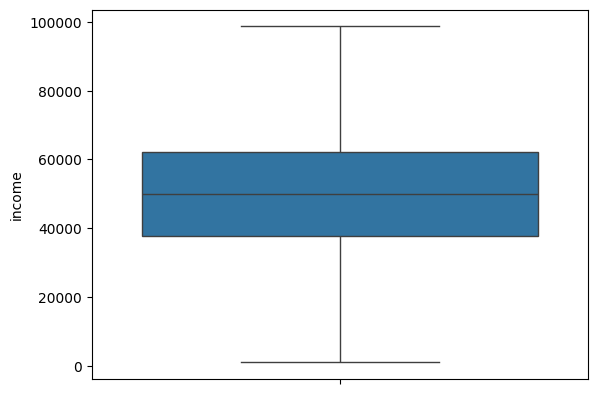

In [46]:
import seaborn as sns
sns.boxplot(df['income'])

DEBTH_COLUMN

In [47]:
med = df['debts'].median()
r1 = df['debts'].quantile(0.25)
q3 = df['debts'].quantile(0.75)
iqr = q3 - r1 
Min_deb = r1 - 1.5 * iqr
Max_deb = q3 + 1.5 * iqr

In [48]:
df['debts'] = np.where(
    df['debts'] < Min_deb,Min_deb,
    np.where(
        df['debts'] > Max_deb,Max_deb,
        df['debts']
    ))

<Axes: ylabel='debts'>

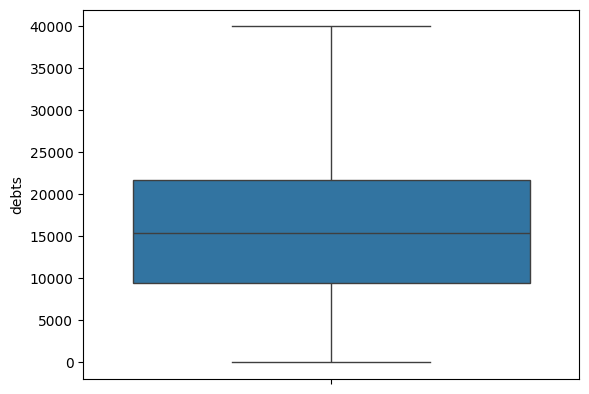

In [49]:
sns.boxplot(df['debts'])

COLUMN_CREDIT_SCORE

In [50]:
df['credit_score'].head()

,credit_score
0,813.0
1,848.0
2,396.0
3,669.0
4,716.0


In [51]:
med = df['credit_score'].median()
r1 = df['credit_score'].quantile(0.25)
q3 = df['credit_score'].quantile(0.75)
iqr = q3 - r1 
Min_crd = r1 - 1.5 * iqr
Max_crd = q3 + 1.5 * iqr

In [52]:
df['credit_score'] = np.where(
    df['credit_score'] < Min_crd,Min_crd,
    np.where(
        df['credit_score'] > Max_crd,Max_crd,
        df['credit_score']
    ))

<Axes: ylabel='credit_score'>

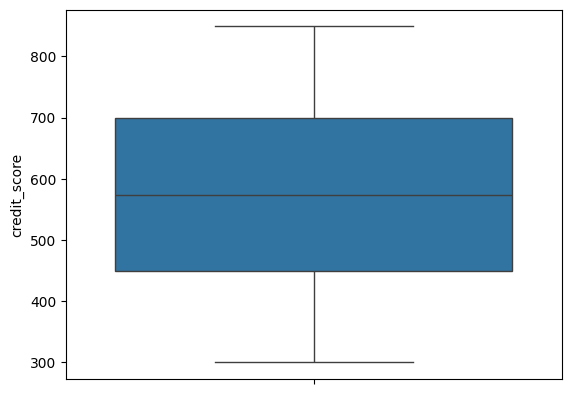

In [53]:
sns.boxplot(df['credit_score'])

In [54]:
med = df['employment_years'].median()
r1 = df['employment_years'].quantile(0.25)
q3 = df['employment_years'].quantile(0.75)
iqr = q3 - r1 
Min_emp = r1 - 1.5 * iqr
Max_emp = q3 + 1.5 * iqr

In [55]:
df['employment_years'] = np.where(
    df['employment_years'] < Min_emp,Min_emp,
    np.where(
        df['employment_years'] > Max_emp,Max_emp,
        df['employment_years']
    ))

<Axes: ylabel='employment_years'>

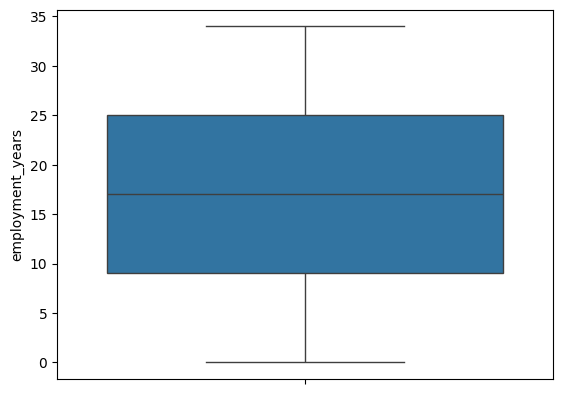

In [56]:
sns.boxplot(df['employment_years'])

LOAN_AMOUNT

In [57]:
a = "	loan_amount	payment_history	age	loan_term"

In [58]:
med = df['loan_amount'].median()
r1 = df['loan_amount'].quantile(0.25)
q3 = df['loan_amount'].quantile(0.75)
iqr = q3 - r1 
Min_loan = r1 - 1.5 * iqr
Max_loan = q3 + 1.5 * iqr

In [59]:
df['loan_amount'] = np.where(
    df['loan_amount'] < Min_loan,Min_loan,
    np.where(
        df['loan_amount'] > Max_loan,Max_loan,
        df['loan_amount']
    ))

<Axes: ylabel='loan_amount'>

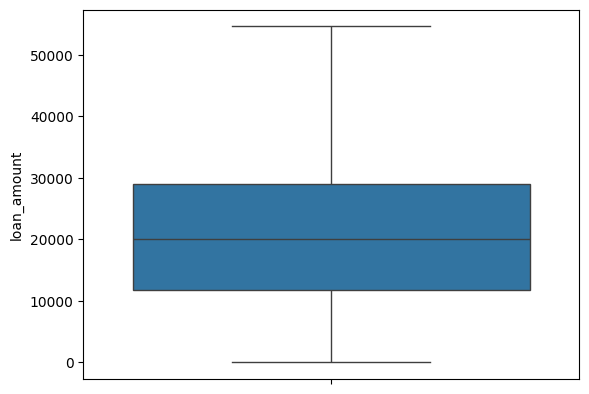

In [60]:
sns.boxplot(df['loan_amount'])

PAYMENT_HISTORY

In [61]:
df['payment_history'].describe()

,payment_history
count,9000.000000
mean,2.526889
std,1.647362
min,0.000000
25%,1.000000
50%,3.000000
75%,4.000000
max,5.000000


<Axes: ylabel='payment_history'>

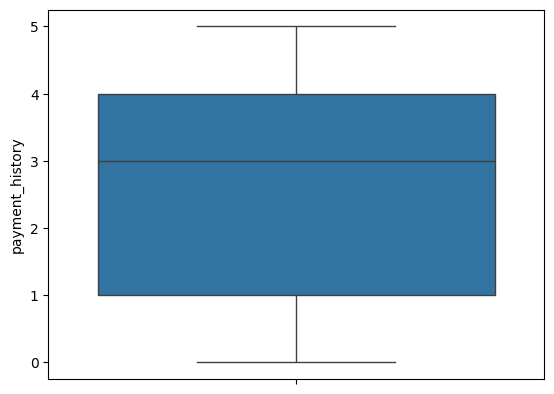

In [62]:
import seaborn as sns
sns.boxplot(df['payment_history'])

AGE

In [63]:
df['age'].describe()

,age
count,9000.000000
mean,44.459667
std,13.329604
min,18.000000
25%,35.000000
50%,43.000000
75%,55.000000
max,69.000000


<Axes: ylabel='age'>

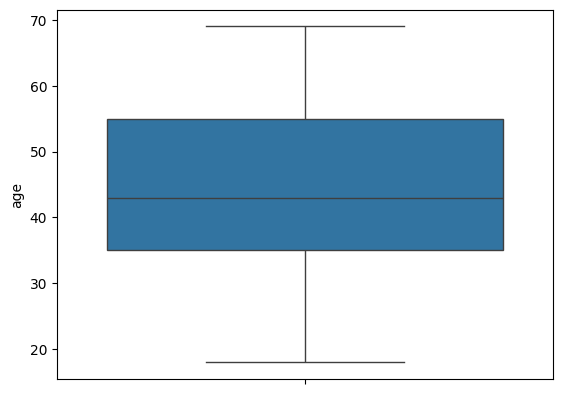

In [64]:
sns.boxplot(df['age'])

LOAN_TERM

<Axes: xlabel='age'>

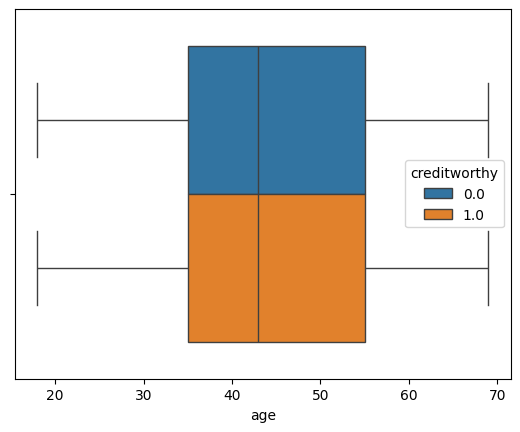

In [65]:
sns.boxplot(data=df, x='age', hue='creditworthy')

In [66]:
df.head(2)

,income,debts,credit_score,employment_years,loan_amount,payment_history,age,loan_term,creditworthy
0,59934.283060,22654.021560,813.0,8.0,15537.525878,3.0,20.0,12.0,0.0
1,47234.713977,25734.127024,848.0,17.0,38487.292308,4.0,65.0,12.0,0.0


TRAIN_TEST_SPLITTING

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [68]:
x = df.drop(columns=['creditworthy'])
y = df['creditworthy']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

FEATURE_SCALING

In [69]:
from sklearn.preprocessing import MinMaxScaler
Scaling = ColumnTransformer(
    transformers=[
        ('scalar',MinMaxScaler(),x_train.columns)
    ],remainder='passthrough'
)


In [70]:

x_train_scal = Scaling.fit_transform(x_train)
x_test_scal = Scaling.transform(x_test)

In [71]:
y_train

,creditworthy
6317,0.0
740,0.0
3781,0.0
7850,0.0
2963,0.0
...,...
5734,0.0
5191,0.0
5390,0.0
860,0.0


HANDLING IMBALANCE DATA

In [72]:
!pip install imbalanced-learn

In [73]:
from imblearn.over_sampling import SMOTE

In [74]:
from sklearn.linear_model import LogisticRegression

In [75]:
model = LogisticRegression(class_weight='balanced')

In [76]:
a = model.fit(x_train_scal,y_train)

# accuracy 

In [77]:
# type(x_train
from sklearn.metrics import accuracy_score

In [78]:
from sklearn.metrics import accuracy_score
y_pred = model.predict(x_test_scal)
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)


0.8661111111111112


In [79]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

In [80]:
cm = confusion_matrix(y_test, y_pred)

In [81]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

In [82]:
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[1370  222]
 [  19  189]]
Precision: 0.45985401459854014
Recall: 0.9086538461538461
F1 Score: 0.6106623586429726


In [ ]:
y_prob = model.predict_proba(x_test_scal)[:,1]
y_pred = (y_prob > 0.6).astype(int)

In [84]:
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print("Confusion Matrix:\n", cm)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Confusion Matrix:
 [[1423  169]
 [  20  188]]
Precision: 0.5266106442577031
Recall: 0.9038461538461539
F1 Score: 0.6654867256637168
